In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow.keras as keras

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

2023-02-16 16:15:50.462344: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-16 16:15:51.056856: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
filename = "model_blast_4_6016_T6"
db = np.load(f"{filename}.npz")
N = db["N"]
P = db["P"]
PLAG = db["PLAG"]
labels = db["labels"]

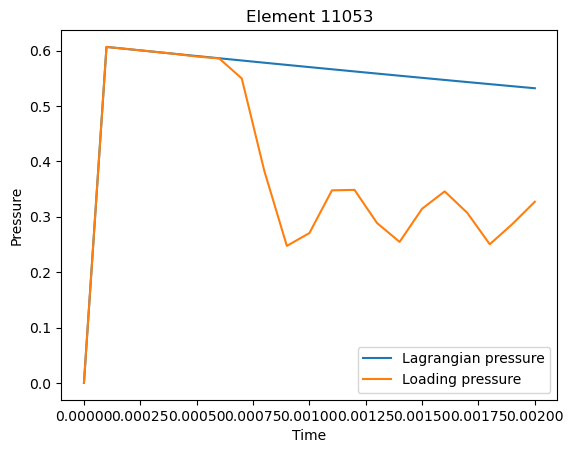

In [3]:
eid = N[-1].argmin()

plt.title(f"Element {labels[eid]}")
plt.plot(PLAG[:,0], PLAG[:,1], label="Lagrangian pressure")
plt.plot(PLAG[:,0], P[:,eid], label="Loading pressure")

plt.legend()
plt.xlabel("Time")
plt.ylabel("Pressure")
plt.show()

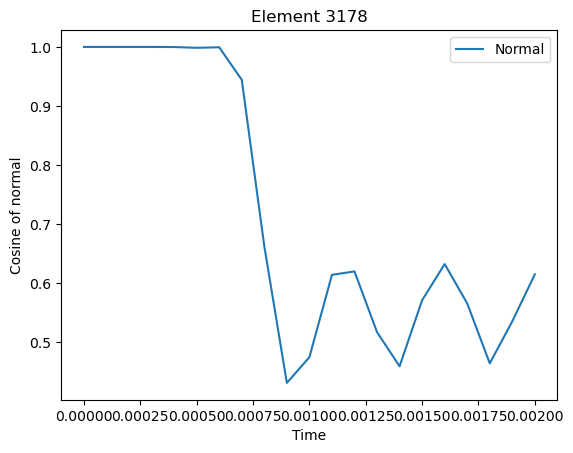

In [4]:
plt.plot(PLAG[:,0], N[:,eid], label="Normal")
plt.title(f"Element {eid}")
plt.xlabel("Time")
plt.ylabel("Cosine of normal")
plt.legend()
plt.show()

In [5]:
def make_model(hidden_layers=[8], act="tanh"):
    model = keras.Sequential()
    model.add(keras.Input(shape=(2,)))
    for layer in hidden_layers:
        model.add(keras.layers.Dense(layer, activation=act))
    model.add(keras.layers.Dense(1, activation="relu"))

    model.compile(optimizer="Nadam", loss="mse")
    return model

def prepare_dataset(lagp, n, p, test_size=0.15):
    lagp_train = np.ones_like(p)
    for i,k in enumerate(lagp[:,1]):
        lagp_train[i] *= k

    lagp_train = lagp_train.flatten()
    p_train = p.flatten()
    n_train = n.flatten()

    X = np.transpose([lagp_train, n_train])
    Y = np.transpose([p_train])

    X,X_norms = normalize(X, axis=0, norm='max', return_norm=True, copy=False)
    Y,Y_norms = normalize(Y, axis=0, norm='max', return_norm=True, copy=False)

    x_train,x_val, y_train, y_val = train_test_split(X, Y, test_size=test_size)

    return x_train,x_val, y_train, y_val, X_norms, Y_norms

In [6]:
x_train,x_val, y_train, y_val, X_norms, Y_norms = prepare_dataset(lagp=PLAG, n=N, p=P)

try:
    model = keras.models.load_model(filename)
    with open(f"{filename}_history.pkl", "rb") as f:
        history = pickle.load(f)
except:
    model = make_model([8], act="tanh")

    history = model.fit(
        x_train,
        y_train,
        batch_size=64,
        epochs=50,
        validation_data=(x_val, y_val),
    )
    model.save(filename)
    with open(f"{filename}_history.pkl", "wb") as f:
        pickle.dump(history, f)

2023-02-16 16:15:55.190368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-16 16:15:55.236424: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-16 16:15:55.236468: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-16 16:15:55.238095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

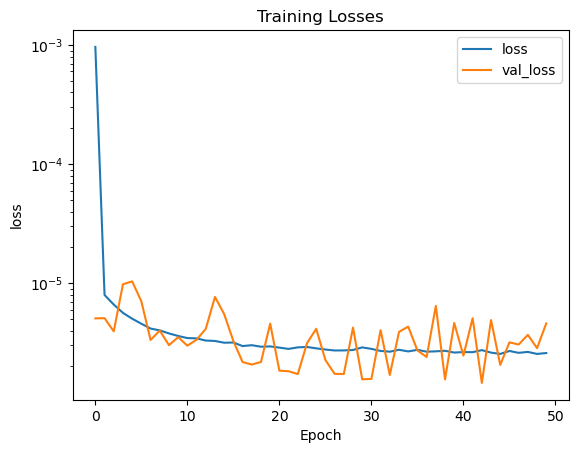

In [7]:
for k,v in history.history.items():
    plt.plot(v,label=f"{k}")

plt.title("Training Losses")
plt.semilogy()
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

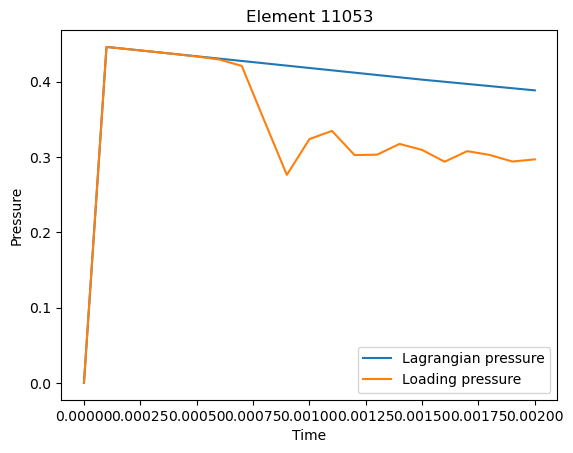

In [8]:
filename2 = "model4_10"
db2 = np.load(f"{filename2}.npz")

N2 = db2["N"]
P2 = db2["P"]
PLAG2= db2["PLAG"]
labels2 = db2["labels"]

plt.title(f"Element {labels[eid]}")
plt.plot(PLAG2[:,0], PLAG2[:,1], label="Lagrangian pressure")
plt.plot(PLAG2[:,0], P2[:,eid], label="Loading pressure")

plt.legend()
plt.xlabel("Time")
plt.ylabel("Pressure")
plt.show()

In [9]:
x_train,x_val, y_train, y_val, X_norms2, Y_norms2 = prepare_dataset(lagp=PLAG2, n=N2, p=P2)

try:
    model2 = keras.models.load_model(filename2)
    with open(f"{filename2}_history.pkl", "rb") as f:
        history2 = pickle.load(f)
except:
    model2 = make_model([8], act="tanh")

    history2 = model2.fit(
        x_train,
        y_train,
        batch_size=64,
        epochs=50,
        validation_data=(x_val, y_val),
    )
    model2.save(filename2)
    with open(f"{filename2}_history.pkl", "wb") as f:
        pickle.dump(history2, f)

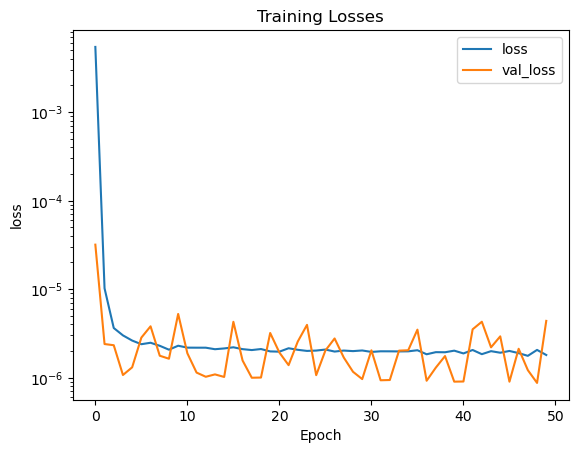

In [10]:
for k,v in history2.history.items():
    plt.plot(v,label=f"{k}")

plt.title("Training Losses")
plt.semilogy()
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

1/1 [==============================] - 0s 16ms/step


2023-02-16 16:16:00.467127: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


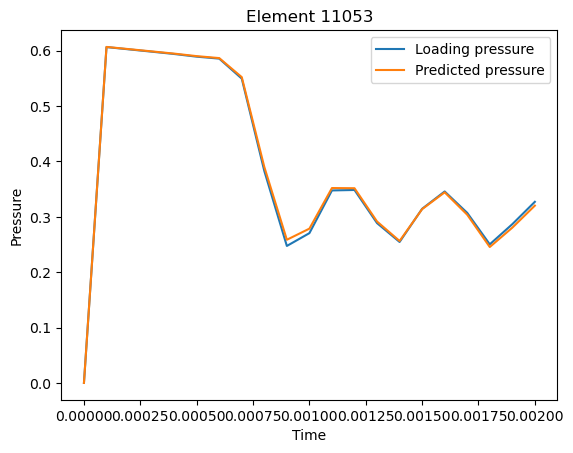

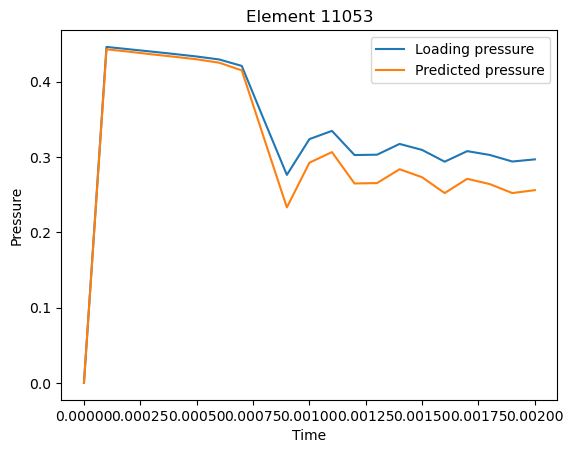

In [11]:
x_predict = np.transpose([PLAG[:,1] / X_norms[0] , N[:, eid] / X_norms[1]])
y_predict = model.predict(x_predict).flatten()*Y_norms[0]

x_predict2 = np.transpose([PLAG2[:,1] / X_norms[0] , N2[:, eid] / X_norms[1]])
y_predict2 = model.predict(x_predict2).flatten()*Y_norms[0]

plt.title(f"Element {labels[eid]}")
#plt.plot(PLAG[:,0], PLAG[:,1], label="Lagrangian pressure")
plt.plot(PLAG[:,0], P[:,eid], label="Loading pressure")
plt.plot(PLAG[:,0], y_predict, label="Predicted pressure")

plt.legend()
plt.xlabel("Time")
plt.ylabel("Pressure")
plt.show()



plt.title(f"Element {labels[eid]}")
#plt.plot(PLAG[:,0], PLAG[:,1], label="Lagrangian pressure")
plt.plot(PLAG2[:,0], P2[:,eid], label="Loading pressure")
plt.plot(PLAG2[:,0], y_predict2, label="Predicted pressure")

plt.legend()
plt.xlabel("Time")
plt.ylabel("Pressure")
plt.show()

1/1 [==============================] - 0s 16ms/step


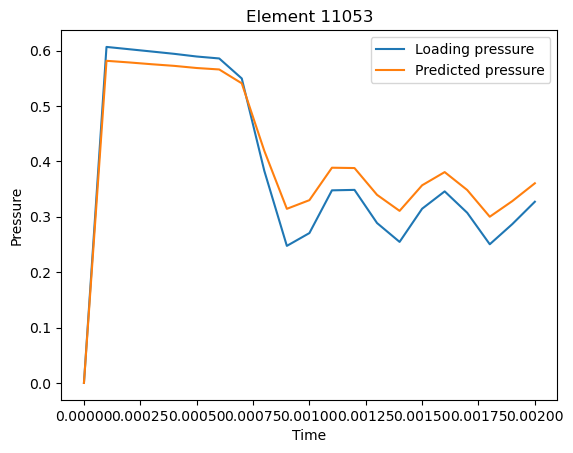

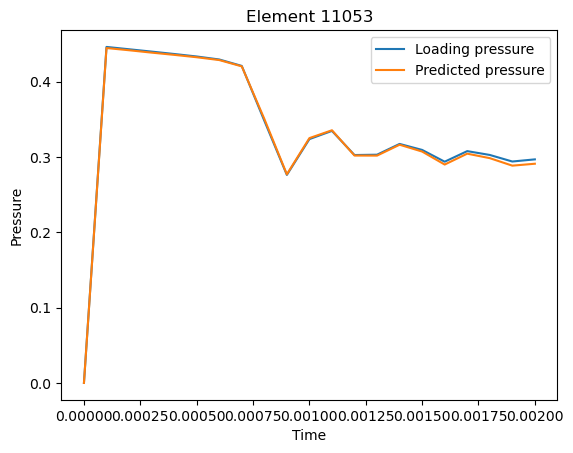

In [12]:
x_predict = np.transpose([PLAG[:,1] / X_norms2[0] , N[:, eid] / X_norms2[1]])
y_predict = model2.predict(x_predict).flatten()*Y_norms2[0]

x_predict2 = np.transpose([PLAG2[:,1] / X_norms2[0] , N2[:, eid] / X_norms2[1]])
y_predict2 = model2.predict(x_predict2).flatten()*Y_norms2[0]

plt.title(f"Element {labels[eid]}")
#plt.plot(PLAG[:,0], PLAG[:,1], label="Lagrangian pressure")
plt.plot(PLAG[:,0], P[:,eid], label="Loading pressure")
plt.plot(PLAG[:,0], y_predict, label="Predicted pressure")

plt.legend()
plt.xlabel("Time")
plt.ylabel("Pressure")
plt.show()



plt.title(f"Element {labels[eid]}")
#plt.plot(PLAG[:,0], PLAG[:,1], label="Lagrangian pressure")
plt.plot(PLAG2[:,0], P2[:,eid], label="Loading pressure")
plt.plot(PLAG2[:,0], y_predict2, label="Predicted pressure")

plt.legend()
plt.xlabel("Time")
plt.ylabel("Pressure")
plt.show()

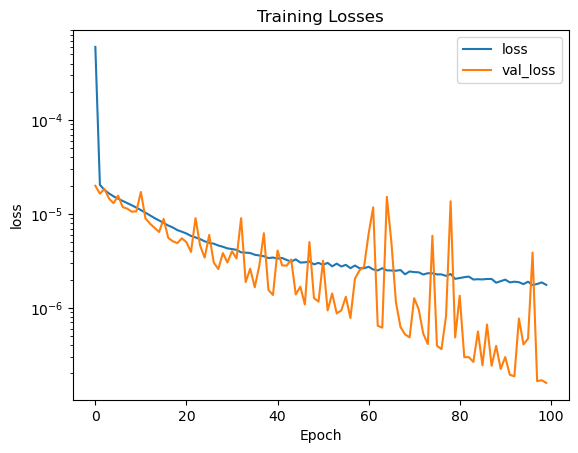

In [13]:
plags = np.concatenate([PLAG,PLAG2])
ns = np.concatenate([N,N2])
ps = np.concatenate([P,P2])

x_train,x_val, y_train, y_val, X_norms3, Y_norms3 = prepare_dataset(lagp=plags, n=ns, p=ps)

filename3 = "both"
try:
    model3 = keras.models.load_model(filename3)
    with open(f"{filename3}_history.pkl", "rb") as f:
        history3 = pickle.load(f)
except:
    model3 = make_model([8], act="tanh")

    history3 = model3.fit(
        x_train,
        y_train,
        batch_size=64,
        epochs=100,
        validation_data=(x_val, y_val),
    )
    model3.save(filename3)
    with open(f"{filename3}_history.pkl", "wb") as f:
        pickle.dump(history3, f)

for k,v in history3.history.items():
    plt.plot(v,label=f"{k}")

plt.title("Training Losses")
plt.semilogy()
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

1/1 [==============================] - 0s 17ms/step


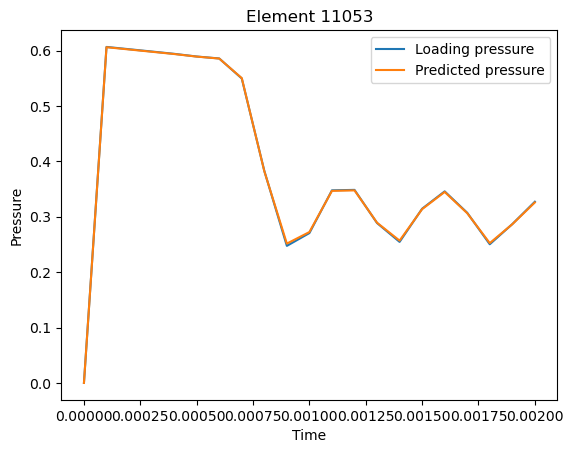

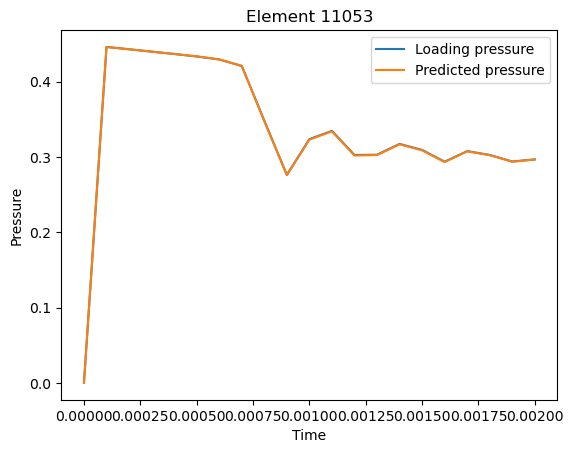

In [14]:
x_predict = np.transpose([PLAG[:,1] / X_norms3[0] , N[:, eid] / X_norms3[1]])
y_predict = model3.predict(x_predict).flatten()*Y_norms3[0]

x_predict2 = np.transpose([PLAG2[:,1] / X_norms3[0] , N2[:, eid] / X_norms3[1]])
y_predict2 = model3.predict(x_predict2).flatten()*Y_norms3[0]

plt.title(f"Element {labels[eid]}")
#plt.plot(PLAG[:,0], PLAG[:,1], label="Lagrangian pressure")
plt.plot(PLAG[:,0], P[:,eid], label="Loading pressure")
plt.plot(PLAG[:,0], y_predict, label="Predicted pressure")

plt.legend()
plt.xlabel("Time")
plt.ylabel("Pressure")
plt.show()



plt.title(f"Element {labels[eid]}")
#plt.plot(PLAG[:,0], PLAG[:,1], label="Lagrangian pressure")
plt.plot(PLAG2[:,0], P2[:,eid], label="Loading pressure")
plt.plot(PLAG2[:,0], y_predict2, label="Predicted pressure")

plt.legend()
plt.xlabel("Time")
plt.ylabel("Pressure")
plt.show()

In [17]:
th = 0.3927

ps = [(30,)]

print(np.sin(th)*30,",", np.cos(th)*30)

11.480528422940456 , 27.71637543276639
